In [1]:
import glob
import re
import pickle
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
data_path = '../../Dataset/jakartaresearch'

In [6]:
files = glob.glob('data/*')

In [7]:
files

['data\\testing.res', 'data\\training.res']

In [8]:
train = pickle.load(open(files[1], 'rb'))
test = pickle.load(open(files[0], 'rb'))

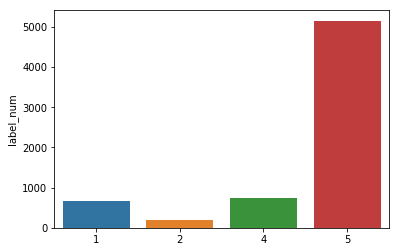

In [9]:
d_train = pd.DataFrame(data={'content': train[0], 'label': train[1]})
d_test = pd.DataFrame(data={'content': test[0], 'label': test[1]})

d_train['label_num'] = d_train.label.apply(lambda x: int(re.sub('Rated | stars out of five stars', '', x)))

d_train = d_train[d_train['label_num'] != 3]

d_test['label_num'] = d_test.label.apply(lambda x: int(re.sub('Rated | stars out of five stars', '', x)))

d_test = d_test[d_test['label_num'] != 3]

plot = sns.barplot(y = d_train.label_num.value_counts(), x = d_train.label_num.value_counts().index)
plot.get_figure().savefig('train_dist.png')

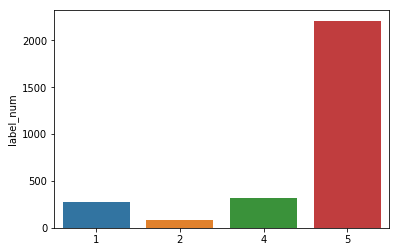

In [10]:
plot = sns.barplot(y = d_test.label_num.value_counts(), x = d_test.label_num.value_counts().index)
plot.get_figure().savefig('test_dist.png')

In [11]:
d_train.loc[d_train.label_num > 3, 'sentiment'] = 1
d_train.loc[d_train.label_num < 3, 'sentiment'] = 0

In [12]:
d_test.loc[d_test.label_num > 3, 'sentiment'] = 1
d_test.loc[d_test.label_num < 3, 'sentiment'] = 0

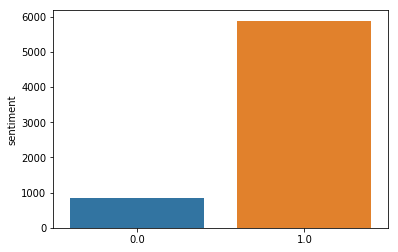

In [13]:
plot = sns.barplot(y = d_train.sentiment.value_counts(), x = d_train.sentiment.value_counts().index)
plot.get_figure().savefig('train_sentiment_dist.png')

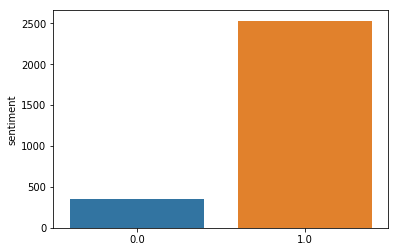

In [14]:
plot = sns.barplot(y = d_test.sentiment.value_counts(), x = d_test.sentiment.value_counts().index)
plot.get_figure().savefig('test_sentiment_dist.png')

In [15]:
d_train.shape

(6747, 4)

In [16]:
d_test.shape

(2886, 4)

## Cleansing

In [17]:
def remove_punctuation(word):
    for punkt in list(string.punctuation):
        word = word.replace(punkt, '')
        
    return word

In [18]:
def cleansing(text):
    text = text.lower()
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1]
    word_list = [remove_punctuation(word) for word in word_list]
    text = ' '.join(word_list)
    
    return text

In [19]:
d_train['content_cleansing'] = d_train.content.apply(cleansing)

d_test['content_cleansing'] = d_test.content.apply(cleansing)

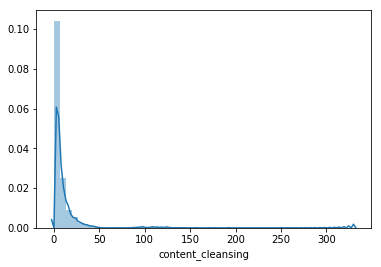

In [20]:
dist_plot = sns.distplot(d_train.content_cleansing.apply(lambda x: len(word_tokenize(x))))
dist_plot.get_figure().savefig('dist_len_words.png')

In [21]:
d_train['cont_clean_len_token'] = d_train.content_cleansing.apply(lambda x: len(word_tokenize(x)))

In [22]:
d_test['cont_clean_len_token'] = d_test.content_cleansing.apply(lambda x: len(word_tokenize(x)))

In [23]:
d_train.drop(d_train[d_train['cont_clean_len_token'] == 0].index, axis = 0, inplace=True)

In [24]:
d_test.drop(d_test[d_test['cont_clean_len_token'] == 0].index, axis = 0, inplace = True)

In [25]:
d_train.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

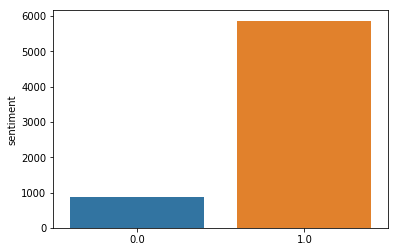

In [26]:
sns.barplot(y = d_train.sentiment.value_counts(), x = d_train.sentiment.value_counts().index)

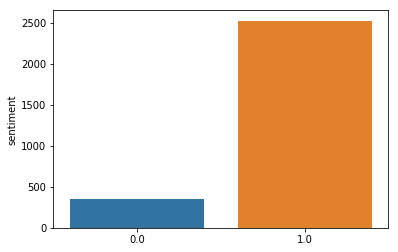

In [27]:
sns.barplot(y = d_test.sentiment.value_counts(), x = d_test.sentiment.value_counts().index)

In [28]:
text = " ".join(d_train.content_cleansing)

In [29]:
idx2word = dict((i, w) for i, w in enumerate(set(word_tokenize(text)), 1))
word2idx = dict((w, i) for i, w in enumerate(set(word_tokenize(text)), 1))

In [30]:
word2idx

{'recoment': 1,
 'bukalapuk': 2,
 'friendy': 3,
 'dipake': 4,
 'headset': 5,
 'unique': 6,
 'gojeknya': 7,
 'krn': 8,
 'menjelaskan': 9,
 'original': 10,
 'menariknya': 11,
 'smooth': 12,
 'wooooooooooooooeewwww': 13,
 'iconlogo': 14,
 'attachment': 15,
 'profesional': 16,
 'sesi': 17,
 '👍🏼👍🏼👍🏼': 18,
 'm10': 19,
 'outfits': 20,
 'konek': 21,
 '18des': 22,
 'semenjak': 23,
 'ongkos': 24,
 'reviewaplikasinya': 25,
 'sby': 26,
 'jgn': 27,
 'utama': 28,
 'tgal': 29,
 'rekanan': 30,
 'goo': 31,
 'indomart': 32,
 'fasterfree': 33,
 'quicker': 34,
 'platfom': 35,
 'bawa': 36,
 'them': 37,
 've': 38,
 'iddiiiihhhh': 39,
 'jurusan': 40,
 'gitulah': 41,
 'dirugikan': 42,
 'pemayaran': 43,
 'lancar': 44,
 'lemari': 45,
 'reviewistri': 46,
 'st': 47,
 'untungnya': 48,
 'supporting': 49,
 'kdpn': 50,
 '1010': 51,
 'duperrrrr': 52,
 'minggu': 53,
 'ditawarkan': 54,
 'mempermudah': 55,
 'lamban': 56,
 'mengingat': 57,
 'user': 58,
 'bliblimart': 59,
 'pu': 60,
 'dibalikin': 61,
 'trimakasih': 62,
 'l

In [31]:
def from_word_to_idx(sentence):
    idx = []
    for word in sentence:
        try:
            idx.append(word2idx[word])
        except:
            pass
    return idx

In [32]:
class Dataset():
    def __init__(self):
        self.lookup = {
            'train': (d_train, len(d_train)),
            'test': (d_test, len(d_test))
        }
        self.set_split('train')
    
    def set_split(self, split = 'train'):
        self._target_split = split
        self._target_df, self._target_size = self.lookup[split]
    
    def __getitem__(self, index):
        sentence = self._target_df.loc[index, 'content_cleansing']
        y = self._target_df.loc[index, 'sentiment']
        
        x = from_word_to_idx(word_tokenize(sentence))
        len_x = len(x)
        if len_x > 50:
            x = x[:50]
        else:
            pad = 50 - len_x
            x = x + [0] * pad
        
        return {
            'x': torch.FloatTensor(x),
            'y': int(y)
        }
    def __len__(self):
        return self._target_size

In [33]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.NeurlNet = nn.Sequential(
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
    
    def forward(self, input_, apply_sigmoid=False):
        x = self.NeurlNet(input_)
        x = x.squeeze()
        if apply_sigmoid:
            x = torch.sigmoid(x)
        
        return x

In [34]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long() #.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [35]:
classifier = Classifier()
dataset = Dataset()

In [36]:
loss_func = nn.BCEWithLogitsLoss()
optimzer = optim.Adam(classifier.parameters(), lr=1e-3)

In [37]:
running_loss_train = 0
running_loss_val = 0
running_acc_train = 0
running_acc_val = 0

In [38]:
history = {
    'acc': [],
    'loss': [],
    'acc_val': [],
    'loss_val': []
}

In [39]:
for epoch in range(100):
    
    classifier.train()
    dataset.set_split('train')
    data_gen = DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=False)
    
    for batch_index, batch_dict in enumerate(data_gen, 1):
        
        # step 1
        optimzer.zero_grad()
        
        # step 2
        y_pred = classifier(batch_dict['x'])
        loss = loss_func(y_pred, batch_dict['y'].float())
        loss_train = loss.item()
        running_loss_train += (loss_train - running_loss_train) / batch_index
        
        # step 3
        acc_train = compute_accuracy(y_pred, batch_dict['y'])
        running_acc_train += (acc_train - running_acc_train) / batch_index
        
        # step 4
        loss.backward()
        
        # step 5
        optimzer.step()
    
    
    classifier.eval()
    dataset.set_split('test')
    data_gen = DataLoader(dataset = dataset, batch_size = 128, shuffle=True, drop_last=False)
    
    for batch_index, batch_dict in enumerate(data_gen, 1):
        y_pred = classifier(batch_dict['x'])
        
        loss = loss_func(y_pred, batch_dict['y'].float())
        
        running_loss_val += (loss.item() - running_loss_val) / batch_index
        
        acc_val = compute_accuracy(y_pred, batch_dict['y'])
        running_acc_val += (acc_val - running_acc_val) / batch_index
                                   
    print("epoch {} loss_train {:.2f} acc_train {:.2f} loss_val {:.2f} acc_val {:.2f}".format(
        epoch, running_loss_train, running_acc_train, running_loss_val, running_acc_val
    ))
    
    history['loss'].append(running_loss_train)
    history['acc'].append(running_acc_train)
    history['loss_val'].append(running_loss_val)
    history['acc_val'].append(running_acc_val)


epoch 0 loss_train 8.62 acc_train 81.63 loss_val 3.69 acc_val 84.82
epoch 1 loss_train 3.00 acc_train 83.63 loss_val 2.31 acc_val 84.42
epoch 2 loss_train 2.12 acc_train 84.80 loss_val 1.71 acc_val 84.15
epoch 3 loss_train 1.62 acc_train 84.88 loss_val 1.50 acc_val 86.51
epoch 4 loss_train 1.22 acc_train 85.42 loss_val 1.75 acc_val 84.01
epoch 5 loss_train 1.09 acc_train 85.68 loss_val 1.11 acc_val 87.36
epoch 6 loss_train 1.00 acc_train 85.59 loss_val 1.08 acc_val 85.15
epoch 7 loss_train 0.76 acc_train 86.45 loss_val 1.28 acc_val 87.24
epoch 8 loss_train 0.75 acc_train 86.19 loss_val 0.88 acc_val 86.28
epoch 9 loss_train 0.81 acc_train 85.24 loss_val 1.18 acc_val 87.41
epoch 10 loss_train 0.76 acc_train 86.64 loss_val 0.98 acc_val 87.38
epoch 11 loss_train 0.56 acc_train 87.70 loss_val 0.78 acc_val 85.99
epoch 12 loss_train 0.47 acc_train 88.03 loss_val 0.75 acc_val 87.41
epoch 13 loss_train 0.47 acc_train 87.40 loss_val 0.76 acc_val 83.93
epoch 14 loss_train 0.50 acc_train 87.59 los

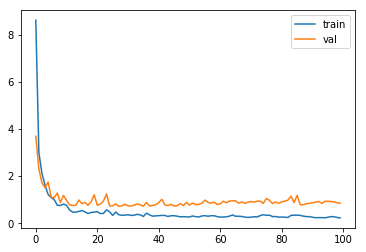

In [40]:
sns.lineplot(y = history['loss'], x = list(range(len(history['loss']))), label = 'train')
sns.lineplot(y = history['loss_val'], x = list(range(len(history['loss']))), label = 'val')
plt.legend()
plt.savefig('loss.png')

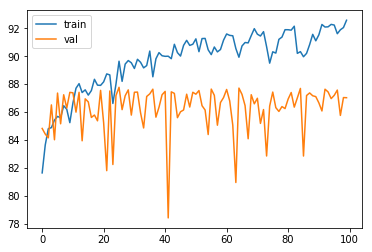

In [41]:
sns.lineplot(y = history['acc'], x = list(range(len(history['loss']))), label = 'train')
sns.lineplot(y = history['acc_val'], x = list(range(len(history['loss']))), label = 'val')
plt.legend()
plt.savefig('accuracy.png')